In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import pandas.plotting.table as table

In [4]:
## Function that accepts a CSV file path as an argument and returns a dataframe.
## Dataframe has a 'timestamp' column and 'metric_value' column that corresponds to http_req_duration
def create_timeseries_df(csv_file_path):
    """
    Creates a timeseries dataframe from a csv path. 

    Args:
     * csv_file_path - string path. 

    Returns:
     * Pandas DF
    
    """
    timeseries_df = pd.read_csv(csv_file_path)
    timeseries_df = timeseries_df[['metric_name', 'timestamp', 'metric_value']]
    timeseries_df = timeseries_df[timeseries_df['metric_name'] == 'http_req_duration'][['timestamp', 'metric_value']]
    timeseries_df = timeseries_df.groupby(timeseries_df['timestamp']).median()
    timeseries_df = timeseries_df.reset_index()
    return timeseries_df

In [9]:
express_timeseries_df = create_timeseries_df('./csv/express_app_timeseries.csv')
fastapi_timeseries_df = create_timeseries_df('./csv/fastapi_app_timeseries.csv')

express_stress_test_timeseries_df = create_timeseries_df('./csv/express_app_stress_test_timeseries.csv')
fastapi_stress_test_timeseries_df = create_timeseries_df('./csv/fastapi_app_stress_test_timeseries.csv')

/var/folders/vp/4cb7qk590lx1914hjkrhzfq80000gn/T/ipykernel_7913/3179433158.py:14: DtypeWarning: Columns (4) have mixed types. Specify dtype option on import or set low_memory=False.
  timeseries_df = pd.read_csv(csv_file_path)


In [51]:
def create_latency_comparison_timeseries_chart(duration_df1, duration_df2, title, test_name="load"):
    """
    Creates and saves a latency comparison table with labels 'Express' and 'FastAPI'. 

    Args:
     * duration_df1, duration_df2: Pandas dfs with column names 'timestamp' and 'metric_value'
     * title: str - Title of figure
     * test_name: 'stress', 'load', or 'spike' test. Determines file name of saved image

    Returns:
     None

    """
    timeseries1 = duration_df1['timestamp'].apply(lambda x: x - duration_df1['timestamp'][0])
    timeseries2 = duration_df2['timestamp'].apply(lambda x: x - duration_df2['timestamp'][0])
    fig, (ax1, ax2) = plt.subplots(2,1)
    ax2.plot(timeseries1, duration_df1['metric_value'], label="Express")
    ax2.plot(timeseries2, duration_df2['metric_value'], label="FastAPI")
    ax2.set_ylabel('Latency (millisecond / request)')
    ax2.set_xlabel('Time Elapsed (s)')
    ax2.set_xticks([0, 30, 60, 90, 120, 150, 180], labels=['0s', '30s', '60s', '90s', '120s', '150s', '180s'])
    ax2.legend()
    df = pd.DataFrame({'http_req_duration_99': {'FastAPI': 1, 'Express':3}, 'http_req_duration_med': {'FastAPI': 2, 'Express': 2}})
    ax1.axis('off')

    ax1.table(cellText=df.values, colLabels=df.columns, rowLabels=["FastAPI", "Express"], loc='top')
    fig.suptitle(title)
    fig.savefig(f"./{test_name}_test_comparison_timeseries.png")
    plt.show()

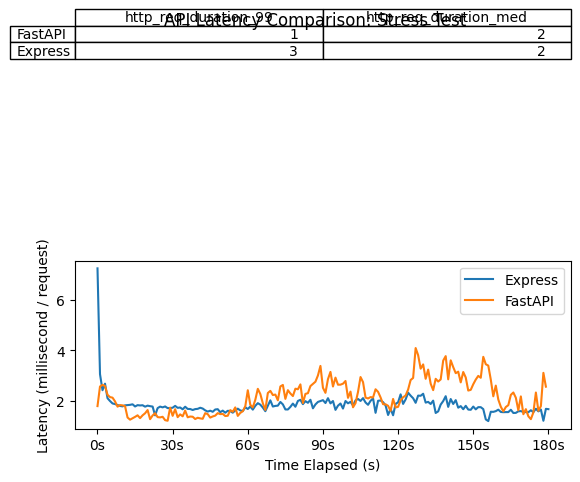

In [52]:
create_latency_comparison_timeseries_chart(express_stress_test_timeseries_df, fastapi_stress_test_timeseries_df, "API Latency Comparison: Stress Test", 'stress')

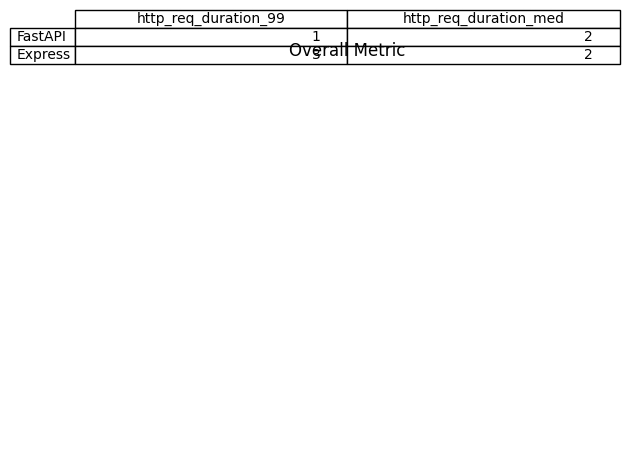

In [38]:
df = pd.DataFrame({'http_req_duration_99': {'FastAPI': 1, 'Express':3}, 'http_req_duration_med': {'FastAPI': 2, 'Express': 2}})
fig, ax = plt.subplots()

# hide axes
fig.patch.set_visible(False)
ax.axis('off')
ax.axis('tight')

ax.table(cellText=df.values, colLabels=df.columns, loc='top', rowLabels=["FastAPI", "Express"])
ax.set_title('Overall Metric')

fig.tight_layout()

plt.show()

In [53]:
import json

In [63]:
data = {}
with open('./summary_outputs/summary_output_load_express.json', 'r') as file:
    my_dict = json.load(file)
    print(my_dict['metrics'])
    data['Req Failed %'] = {'Express': my_dict['metrics']['http_req_failed']['values']['rate']}
    data['Med Duration (ms)'] = {'Express': my_dict['metrics']['http_req_duration']['values']['med']}
    data['p95 (ms)'] = {'Express': my_dict['metrics']['http_req_duration']['values']['p(95)']}
    data['p99 (ms)'] = {'Express': my_dict['metrics']['http_req_duration']['values']['p(99)']}
pd.DataFrame(data)
    

{'http_req_duration': {'values': {'p(95)': 2.2616499999999995, 'med': 1.483, 'p(99)': 2.684}, 'type': 'trend', 'contains': 'time'}, 'iteration_duration': {'type': 'trend', 'contains': 'time', 'values': {'med': 1002.817636, 'p(99)': 1003.5067465, 'p(95)': 1003.2230956}}, 'iterations': {'values': {'count': 12048, 'rate': 66.75268203333944}, 'type': 'counter', 'contains': 'default'}, 'http_reqs': {'values': {'count': 12048, 'rate': 66.75268203333944}, 'type': 'counter', 'contains': 'default'}, 'http_req_failed': {'values': {'passes': 0, 'fails': 12048, 'rate': 0}, 'type': 'rate', 'contains': 'default'}}


,Req Failed %,Med Duration (ms),p95 (ms),p99 (ms)
Express,0,1.483,2.26165,2.684
